In [8]:
import mlrose_hiive as mlrose
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [9]:
SEED=11

In [10]:
def callback(**kwargs):
    stats.append(kwargs)
    return True

In [11]:
fitness = mlrose.FourPeaks(t_pct=0.1)
input_sizes=[10,25,50]

# Randomized Hill Climbing

In [12]:
problem = mlrose.DiscreteOpt(25, fitness, maximize=True, max_val=2)
problem.find_neighbors()
len(problem.neighbors)

25

In [13]:
problem = mlrose.DiscreteOpt(25, fitness, maximize=True, max_val=2)
rhc = mlrose.RHCRunner(problem=problem,
                    experiment_name="rhc",
                    output_directory=None,
                    seed=SEED,
                    iteration_list=[1000],
                    max_attempts=25,
                    restart_list=[200])   

df_run_stats, df_run_curves = rhc.run()

best_fitness = df_run_curves['Fitness'].max()
stopping_stats=df_run_stats[(df_run_stats['Iteration']==df_run_stats['max_iters'])&(df_run_stats['Fitness']==best_fitness)].drop(columns=['Iteration','Restarts'])
print(f"Found fitness score of {best_fitness} roughly every {df_run_stats.loc[0]['Restarts']/(stopping_stats.shape[0]):.3f} restarts")
stopping_stats

Found fitness score of 46.0 roughly every 200.000 restarts


,Fitness,FEvals,Time,State,max_iters,current_restart
61,46.0,1823,0.336476,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1000,30


==========Input Size 10=================
[1 1 1 1 1 1 1 1 0 0] 18.0
Number of Iterations: 2568
Number of Fitness Evaluations: 2698
Average Fitness Evaluations per Iteration: 1.051
Wall Clock Time: 0.013972
==========Input Size 25=================
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 46.0
Number of Iterations: 2830
Number of Fitness Evaluations: 2923
Average Fitness Evaluations per Iteration: 1.033
Wall Clock Time: 0.01379
==========Input Size 50=================
[1 1 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0
 1 0 0 0 1 0 1 0 0 0 0 0 0] 57.0
Number of Iterations: 1855
Number of Fitness Evaluations: 1848
Average Fitness Evaluations per Iteration: 0.996
Wall Clock Time: 0.00905


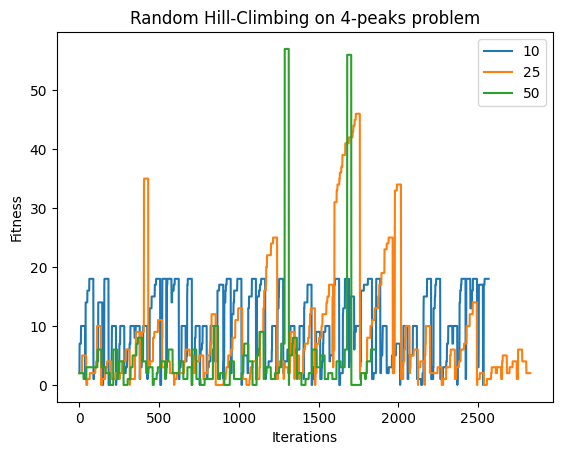

In [14]:
rhc_results=dict()
for input_size in input_sizes:
    problem = mlrose.DiscreteOpt(input_size, fitness, maximize=True, max_val=2)
    stats=[]
    
    start_time=datetime.now()
    best_state,best_fitness,fitness_curve=mlrose.random_hill_climb(problem,
                                                       random_state=SEED,
                                                                   max_attempts=25,
                                                                   restarts=50,
                                                       state_fitness_callback=callback,
                                                       callback_user_info=[])
    wall_clock_time=(datetime.now()-start_time).total_seconds()
    print(f'==========Input Size {input_size}=================')
    print(best_state,best_fitness)
    print(f"Number of Iterations: {len(stats)}")
    print(f"Number of Fitness Evaluations: {stats[-1]['fitness_evaluations']}")
    print(f"Average Fitness Evaluations per Iteration: {stats[-1]['fitness_evaluations']*1.0/len(stats):.3f}")
    print(f"Wall Clock Time: {wall_clock_time}")
    plt.plot([i['fitness'] for i in stats],label=input_size)
    plt.xlabel("Iterations")
    plt.ylabel("Fitness")
    

    rhc_results[input_size]={
        'fitness_curve':[i['fitness'] for i in stats],
        'n_iterations': len(stats),
        'n_evals': stats[-1]['fitness_evaluations'],
        'best_fitness':best_fitness,
        'best_state':best_state,
        'wall_clock_time':wall_clock_time
    }

plt.title(f"Random Hill-Climbing on 4-peaks problem")
plt.legend(loc='best')

# Simulated Annealing

In [26]:
problem = mlrose.DiscreteOpt(25, fitness, maximize=True, max_val=2)
temperature=[1,10,50,100]*10
decay=[0.01,0.1,0.5,0.9,0.99]
temperature_list=[mlrose.GeomDecay(init_temp=t, decay=d) for t in temperature for d in decay]
sa = mlrose.SARunner(problem=problem,
              experiment_name='sa',
              seed=None,
              iteration_list=[10000],
              max_attempts=25,
              temperature_list=temperature_list)

# the two data frames will contain the results
df_run_stats, df_run_curves = sa.run()
df_run_stats['init_temp']=df_run_stats['Temperature'].apply(lambda x: x.init_temp)
df_run_stats['decay']=df_run_stats['Temperature'].apply(lambda x: x.decay)


best_fitness = df_run_stats['Fitness'].max()

agg_runs=df_run_stats[df_run_stats['Iteration']!=0].groupby(['init_temp','decay']).agg({"Fitness":"mean","FEvals":"mean","Time":"mean"})
agg_runs.sort_values(['Fitness','FEvals'],ascending=[False,True])

Fitness  FEvals      Time
init_temp decay                           
50        0.99      45.6  1027.1  0.049357
100       0.99      45.6  1102.5  0.054088
          0.10      45.5   325.4  0.024151
50        0.90      45.2   426.7  0.026593
          0.50      45.0   445.9  0.026978
100       0.01      43.5   367.9  0.025579
10        0.50      43.3   385.7  0.024535
50        0.10      43.3   424.1  0.026477
100       0.50      43.2   318.6  0.024023
          0.90      43.2   413.0  0.026602
1         0.50      43.1   357.2  0.022675
          0.10      41.5   319.9  0.021613
          0.01      41.5   349.9  0.023583
          0.99      41.5   439.9  0.025475
10        0.99      41.4   689.4  0.033725
1         0.90      39.6   360.4  0.023149
10        0.10      39.3   368.6  0.023575
50        0.01      39.3   393.5  0.025615
10        0.01      37.0   357.2  0.022770
          0.90      36.4   396.3  0.024051

==========Input Size 10=================
[1 1 1 1 1 1 1 1 0 0] 18.0
Number of Iterations: 269
Number of Fitness Evaluations: 406
Average Fitness Evaluations per Iteration: 1.509
Wall Clock Time: 0.008733
==========Input Size 25=================
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 46.0
Number of Iterations: 471
Number of Fitness Evaluations: 757
Average Fitness Evaluations per Iteration: 1.607
Wall Clock Time: 0.005404
==========Input Size 50=================
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0] 93.0
Number of Iterations: 1471
Number of Fitness Evaluations: 2347
Average Fitness Evaluations per Iteration: 1.596
Wall Clock Time: 0.013845


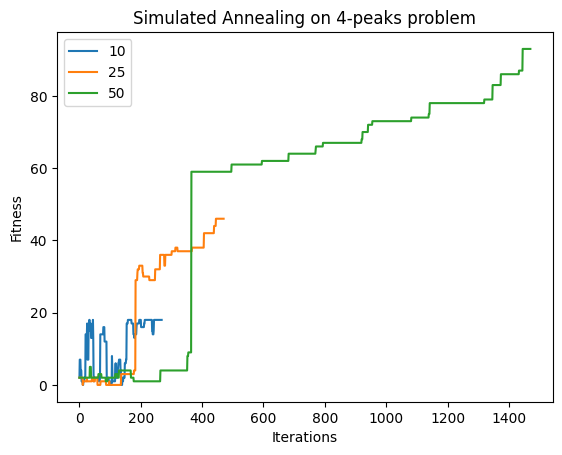

In [15]:
sa_results=dict()
for input_size in input_sizes:
    problem = mlrose.DiscreteOpt(input_size, fitness, maximize=True, max_val=2)
    stats=[]
    
    start_time=datetime.now()
    best_state,best_fitness,fitness_curve=mlrose.simulated_annealing(problem,
                                     schedule=mlrose.GeomDecay(init_temp=10, decay=0.99, min_temp=0.001),
                                     max_attempts=25,
                                     random_state=SEED,
                                    state_fitness_callback=callback,
                                   callback_user_info=[])
    wall_clock_time=(datetime.now()-start_time).total_seconds()
    print(f'==========Input Size {input_size}=================')
    print(best_state,best_fitness)
    print(f"Number of Iterations: {len(stats)}")
    print(f"Number of Fitness Evaluations: {stats[-1]['fitness_evaluations']}")
    print(f"Average Fitness Evaluations per Iteration: {stats[-1]['fitness_evaluations']*1.0/len(stats):.3f}")
    print(f"Wall Clock Time: {wall_clock_time}")
    plt.plot([i['fitness'] for i in stats],label=input_size)
    plt.xlabel("Iterations")
    plt.ylabel("Fitness")
    

    sa_results[input_size]={
        'fitness_curve':[i['fitness'] for i in stats],
        'n_iterations': len(stats),
        'n_evals': stats[-1]['fitness_evaluations'],
        'best_fitness':best_fitness,
        'best_state':best_state,
        'wall_clock_time':wall_clock_time
    }

plt.title(f"Simulated Annealing on 4-peaks problem")
plt.legend(loc='best')

# Genetic

==========Input Size 10=================
[1 1 1 1 0 0 0 0 0 0] 16.0
Number of Iterations: 27
Number of Fitness Evaluations: 567
Average Fitness Evaluations per Iteration: 21.000
Wall Clock Time: 0.011286
==========Input Size 25=================
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 46.0
Number of Iterations: 89
Number of Fitness Evaluations: 1880
Average Fitness Evaluations per Iteration: 21.124
Wall Clock Time: 0.03151
==========Input Size 50=================
[1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0] 67.0
Number of Iterations: 80
Number of Fitness Evaluations: 1689
Average Fitness Evaluations per Iteration: 21.113
Wall Clock Time: 0.031622


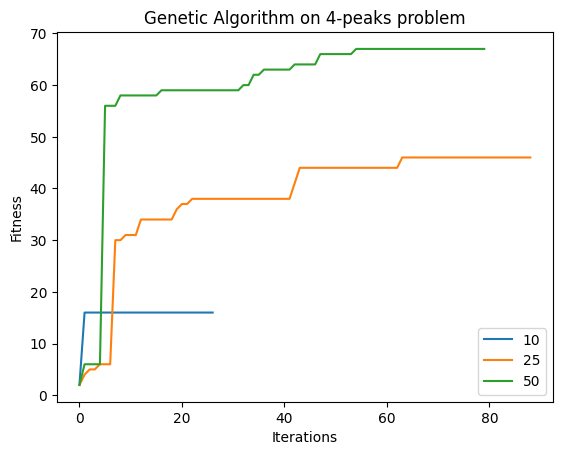

In [16]:
ga_results=dict()
for input_size in input_sizes:
    problem = mlrose.DiscreteOpt(input_size, fitness, maximize=True, max_val=2)
    problem = mlrose.DiscreteOpt(problem.length, fitness, maximize=True, max_val=2,
                             crossover=mlrose.algorithms.crossovers.OnePointCrossOver(problem),
                            mutator=mlrose.algorithms.mutators.DiscreteMutator(problem))
    stats=[]
    
    start_time=datetime.now()
    best_state,best_fitness,fitness_curve=mlrose.genetic_alg(problem,
                                                             pop_size=20,
                                                             mutation_prob=0.01,
                                                             max_attempts=25,
                                                       random_state=SEED,
                                                       state_fitness_callback=callback,
                                                       callback_user_info=[])
    wall_clock_time=(datetime.now()-start_time).total_seconds()
    print(f'==========Input Size {input_size}=================')
    print(best_state,best_fitness)
    print(f"Number of Iterations: {len(stats)}")
    print(f"Number of Fitness Evaluations: {stats[-1]['fitness_evaluations']}")
    print(f"Average Fitness Evaluations per Iteration: {stats[-1]['fitness_evaluations']*1.0/len(stats):.3f}")
    print(f"Wall Clock Time: {wall_clock_time}")
    plt.plot([i['fitness'] for i in stats],label=input_size)
    plt.xlabel("Iterations")
    plt.ylabel("Fitness")
    

    ga_results[input_size]={
        'fitness_curve':[i['fitness'] for i in stats],
        'n_iterations': len(stats),
        'n_evals': stats[-1]['fitness_evaluations'],
        'best_fitness':best_fitness,
        'best_state':best_state,
        'wall_clock_time':wall_clock_time
    }

plt.title(f"Genetic Algorithm on 4-peaks problem")
plt.legend(loc='best')

# MIMIC

==========Input Size 10=================
[1 1 1 1 1 1 1 1 0 0] 18.0
Number of Iterations: 12
Number of Fitness Evaluations: 2412
Average Fitness Evaluations per Iteration: 201.000
Wall Clock Time: 0.140518
==========Input Size 25=================
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 46.0
Number of Iterations: 31
Number of Fitness Evaluations: 6237
Average Fitness Evaluations per Iteration: 201.194
Wall Clock Time: 2.08518
==========Input Size 50=================
[1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0] 68.0
Number of Iterations: 31
Number of Fitness Evaluations: 6238
Average Fitness Evaluations per Iteration: 201.226
Wall Clock Time: 8.704698


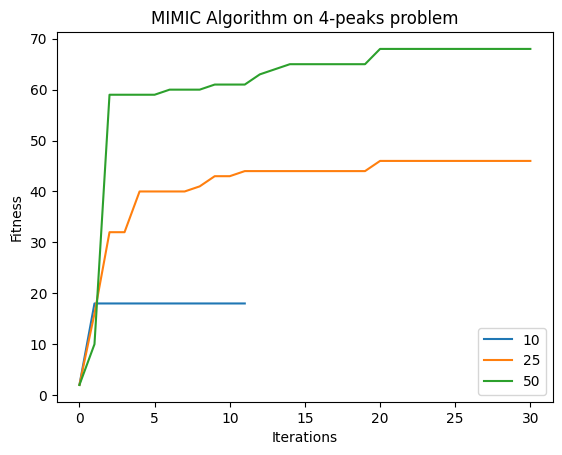

In [17]:
mimic_results=dict()
for input_size in input_sizes:
    problem = mlrose.DiscreteOpt(input_size, fitness, maximize=True, max_val=2)   
    problem.reset()
    stats=[]
    start_time=datetime.now()
    best_state,best_fitness,fitness_curve=mlrose.mimic(problem,
                                                       random_state=SEED,
                                                       pop_size=200,
                                                       keep_pct=0.3,
                                                       max_attempts=10,
                                                       state_fitness_callback=callback,
                                                       callback_user_info=[])
    wall_clock_time=(datetime.now()-start_time).total_seconds()
    print(f'==========Input Size {input_size}=================')
    print(best_state,best_fitness)
    print(f"Number of Iterations: {len(stats)}")
    print(f"Number of Fitness Evaluations: {stats[-1]['fitness_evaluations']}")
    print(f"Average Fitness Evaluations per Iteration: {stats[-1]['fitness_evaluations']*1.0/len(stats):.3f}")
    print(f"Wall Clock Time: {wall_clock_time}")
    plt.plot([i['fitness'] for i in stats],label=input_size)
    plt.xlabel("Iterations")
    plt.ylabel("Fitness")
    

    mimic_results[input_size]={
        'fitness_curve':[i['fitness'] for i in stats],
        'n_iterations': len(stats),
        'n_evals': stats[-1]['fitness_evaluations'],
        'best_fitness':best_fitness,
        'best_state':best_state,
        'wall_clock_time':wall_clock_time
    }

plt.title(f"MIMIC Algorithm on 4-peaks problem")
plt.legend(loc='best')

# Comparison

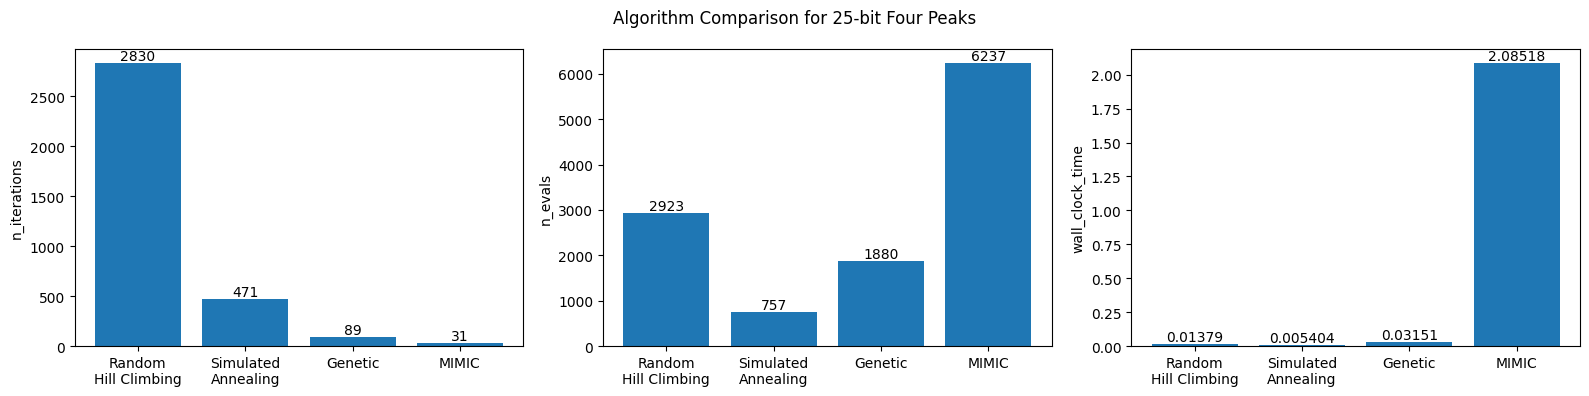

In [20]:
input_size=25
x=['Random\nHill Climbing','Simulated\nAnnealing','Genetic','MIMIC']
y=[rhc_results,sa_results,ga_results,mimic_results]
plots=['n_iterations','n_evals','wall_clock_time']
fig,axs=plt.subplots(1,3,figsize=(16,4))
best_fitness=max([alg[input_size]['best_fitness'] for alg in y])

for p,ax in zip(plots,axs):
    bars=[]
    bars.append(ax.bar(x,[alg[input_size][p] for alg in y]))
    for bar in bars:
        for b,alg in zip(bar,y):
            if alg[input_size]['best_fitness']!=best_fitness:
                b.set(hatch='/')
        ax.bar_label(bar)
                
    ax.set_ylabel(p)
plt.suptitle("Algorithm Comparison for 25-bit Four Peaks")
plt.tight_layout()

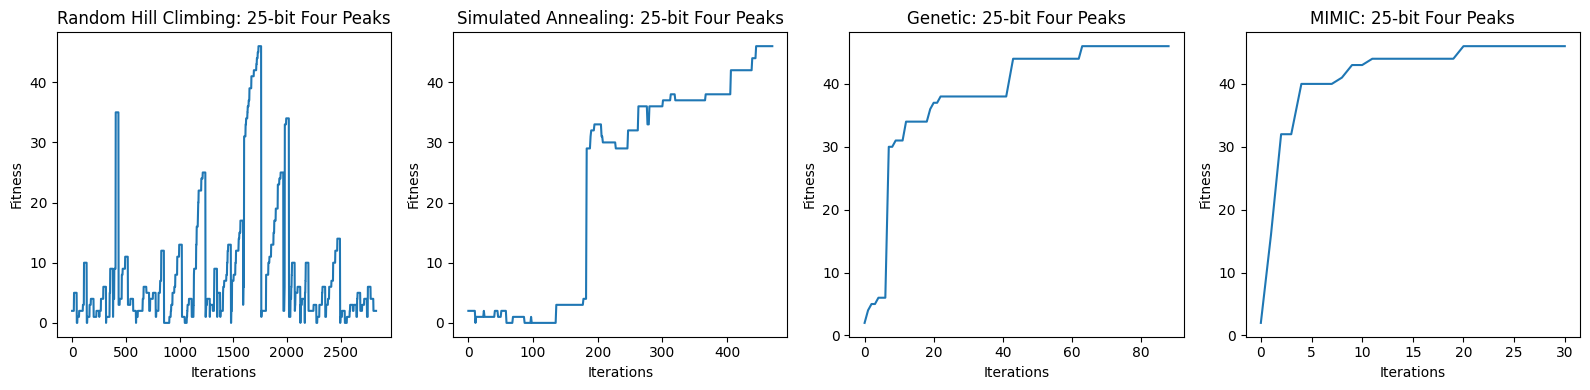

In [19]:
i=input_size
fig,axs=plt.subplots(1,4,figsize=(16,4))
x=['Random Hill Climbing','Simulated Annealing','Genetic','MIMIC']
y=[rhc_results,sa_results,ga_results,mimic_results]
for alg,results,ax in zip(x,y,axs):
    ax.set_title(f"{alg}: {i}-bit Four Peaks")
    ax.plot(results[i]['fitness_curve'])
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Fitness")
plt.tight_layout()